In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math

%matplotlib inline


def normalize(array, maximum=None):
    if maximum is None:
        maximum = array.max()
    normalized = array / maximum
    return normalized


def get_coefs(target, real):
    return target[0] / real[0], target[1] / real[1], target[2] / real[2] 


def get_coefs_for_gray_world(avgs, avg_all):
    return avgs[0] / avg_all, avgs[1] / avg_all, avgs[2] / avg_all 



def correction_channel(channel, func):
    np_func = np.vectorize(func)
    channel = np_func(channel)
    return channel


def merge_normalized_channels(channels, need_normalize=True):
    theshold = np.vectorize(lambda x: min(1.0, x))
    new_image = []
    for c in channels:
        channel = c
        if need_normalize:
            channel = normalize(channel) * 255
        new_image.append(channel.astype('uint8'))
        
    return cv2.merge(new_image)


def split_to_normalized_channels(input_image):
    b, g, r = cv2.split(input_image)
    return b.astype('uint16'), g.astype('uint16'), r.astype('uint16')
#     return normalize(b, 255), normalize(g, 255), normalize(r, 255)


def color_correction_by_reference_color(image, target_color, selected_color):
    coefs = get_coefs(target_color, selected_color)
    
    b, g, r = split_to_normalized_channels(image)
    b = correction_channel(b, lambda x: x * coefs[0])
    g = correction_channel(g, lambda x: x * coefs[1])
    r = correction_channel(r, lambda x: x * coefs[2])

    corrected_image = merge_normalized_channels((b, g, r), need_normalize=False)
    return corrected_image


def color_correction_by_gray_world(image):
    b, g, r = cv2.split(original_image)
    
    avg_b = np.average(b)
    avg_g = np.average(g)
    avg_r = np.average(r)
    avg_all = (avg_b + avg_g + avg_r) / 3

    coefs = get_coefs_for_gray_world((avg_b, avg_g, avg_r), avg_all)
    
    b = correction_channel(b, lambda x: x * coefs[0])
    g = correction_channel(g, lambda x: x * coefs[1])
    r = correction_channel(r, lambda x: x * coefs[2])
    
    return merge_normalized_channels((b, g, r), need_normalize=False)
    
    
def color_correction_by_func(image, func):
    b, g, r = split_to_normalized_channels(image)
    b = correction_channel(b, func)
    g = correction_channel(g, func)
    r = correction_channel(r, func)

    corrected_image = merge_normalized_channels((b, g, r))
    return corrected_image


def color_correction_by_normalizing_hist(image):
    b, g, r = split_to_normalized_channels(image)

    b = normalize(b - b.min()) * 255
    g = normalize(g - g.min()) * 255
    r = normalize(r - r.min()) * 255

    corrected_image = merge_normalized_channels((b, g, r))
    return corrected_image


def equalize(pixel, sdf, count, gray_levels):
    sdf_min = sdf.min()
    return round(sdf[pixel] / count * (gray_levels - 1))


def equalize_channel(channel):
    gray_levels = 256
    pixel_count = len(channel) * len(channel[0])
    histogram, _ = np.histogram(channel, bins=gray_levels)
    
    sdf = histogram.cumsum()
    
    equalize_histogram = np.vectorize(lambda x: equalize(x, sdf, pixel_count, gray_levels))
    channel = equalize_histogram(channel)
    return channel


def color_correction_by_equalizing_histogram_in_hsv(image):
    h, s, l = cv2.split(cv2.cvtColor(image, cv2.COLOR_BGR2HSV))
    l = equalize_channel(l)
    merged = np.dstack((h, s, l)).astype('uint8')
    corrected_image = cv2.cvtColor(merged, cv2.COLOR_HSV2BGR)
    return corrected_image


def color_correction_by_equalizing_histogram_in_rgb(image):
    b, g, r = split_to_normalized_channels(image)
    
    b = equalize_channel(b)
    g = equalize_channel(g)
    r = equalize_channel(r)

    corrected_image = merge_normalized_channels((b, g, r))
    return corrected_image


def get_histogram(image):
    pixels = list(image)
    histogram = [0 for i in range(256)]
    for pixel in pixels:
        histogram[int(pixel)] += 1
    return histogram


def plot_hist(image):
    gray_levels = 256
    names = range(gray_levels)
    r, g, b = cv2.split(image)
    
    r_hist, _ = np.histogram(r, bins=gray_levels)
    g_hist, _ = np.histogram(g, bins=gray_levels)
    b_hist, _ = np.histogram(b, bins=gray_levels)
    
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex='col', figsize=(16, 2))
    
    ax1.bar(names, r_hist, color='red', width=1.0)
    ax1.set_title('red channel')
    
    ax2.bar(names, g_hist, color='red', width=1.0)
    ax2.set_title('green channel')
    
    ax3.bar(names, b_hist, color='red', width=1.0)
    ax3.set_title('blue channel')
    
    plt.show()

    
def plot_images(first, second, need_histogram=False):
    print('Original and corrected images')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10))
    
    ax1.imshow(cv2.cvtColor(first, cv2.COLOR_BGR2RGB))
    ax2.imshow(cv2.cvtColor(second, cv2.COLOR_BGR2RGB))

    plt.show()
    
    if need_histogram:
        print('Original image histogram (in RGB)')
        plot_hist(cv2.cvtColor(first, cv2.COLOR_BGR2RGB))
        print('Corrected image histogram (in RGB)')
        plot_hist(cv2.cvtColor(second, cv2.COLOR_BGR2RGB))

# Загрузка изображения

# Цветовая коррекция изображений
## Коррекция с опорным цветом

Original and corrected images


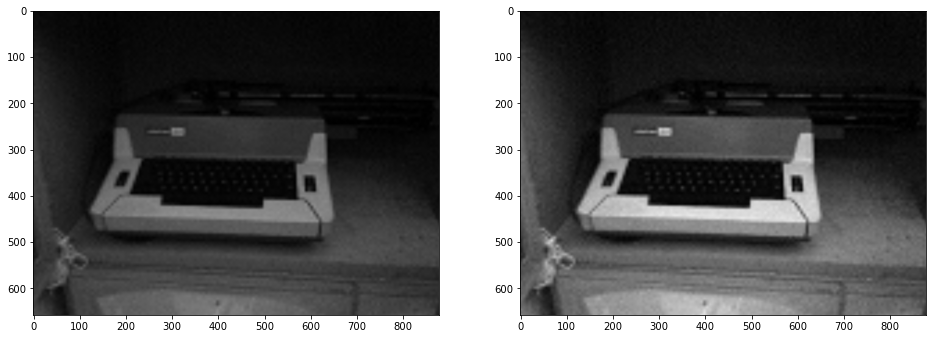

In [2]:
destination_color = (160, 160, 160)
source_color = (100, 100, 100)
original_image = cv2.imread('img/printer1.png')

corrected_image = color_correction_by_reference_color(
    original_image, destination_color, source_color)

plot_images(original_image, corrected_image)

## Серый мир

Original and corrected images


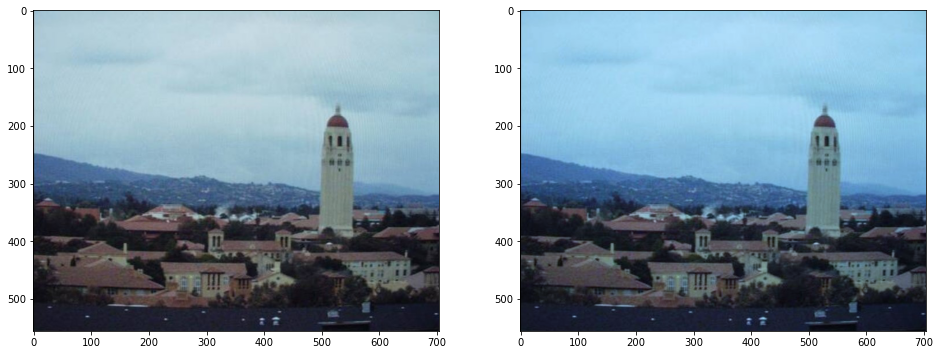

In [3]:
original_image = cv2.imread('img/example1.jpg')
corrected_image = color_correction_by_gray_world(original_image)

plot_images(original_image, corrected_image)

## По виду функции преобразования

### math.sqrt(x)* 10

Original and corrected images


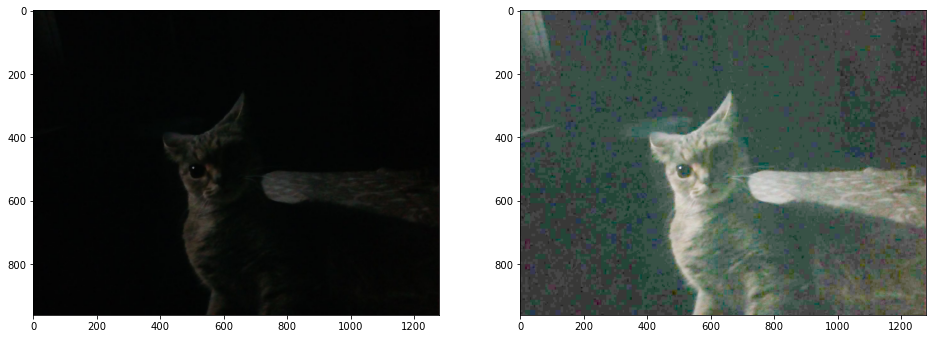

In [4]:
original_image = cv2.imread('img/night3.jpeg')

bad_function = lambda x: math.log(x if x > 0 else 1) * 15
corrected_image = color_correction_by_func(original_image, bad_function)

plot_images(original_image, corrected_image)

### x**1.154

Original and corrected images


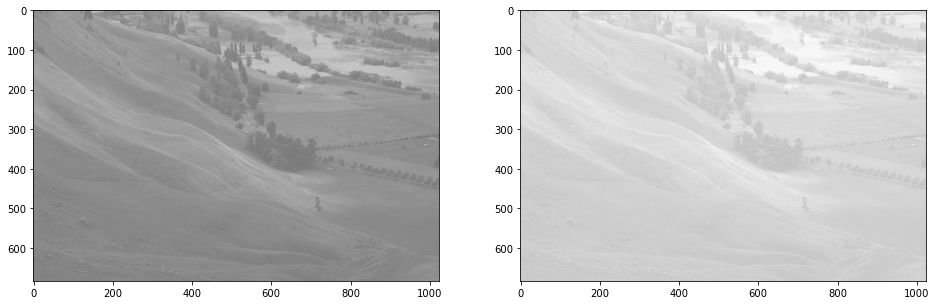

In [5]:
original_image = cv2.imread('img/mountain4.jpg')
good_function = lambda x: 2 * x**0.5
corrected_image = color_correction_by_func(original_image, good_function)

plot_images(original_image, corrected_image)

# Коррекция на основе гистограммы
## Нормализация гистограммы

Original and corrected images


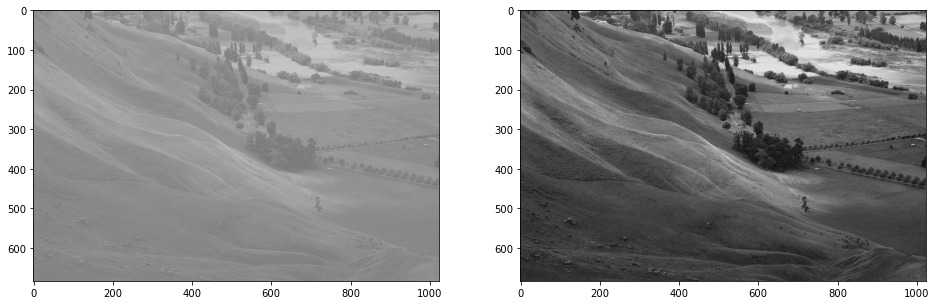

Original image histogram (in RGB)


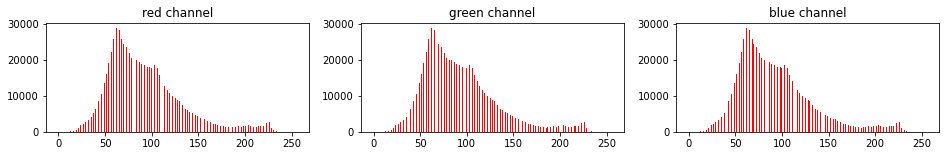

Corrected image histogram (in RGB)


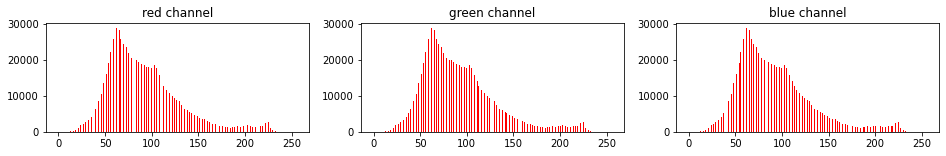

In [6]:
# original_image = cv2.imread('img/mountain4.jpg')
corrected_image = color_correction_by_normalizing_hist(original_image)

plot_images(original_image, corrected_image, need_histogram=True)

## Эквализация гистограммы

### RGB

Original and corrected images


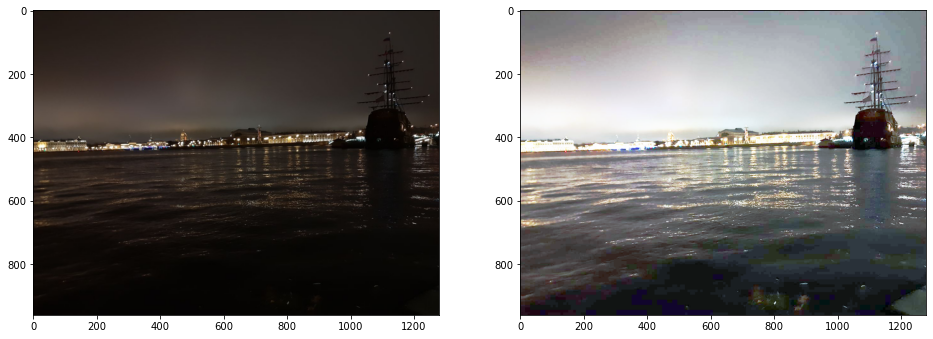

Original image histogram (in RGB)


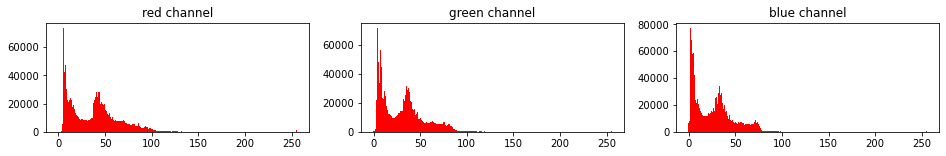

Corrected image histogram (in RGB)


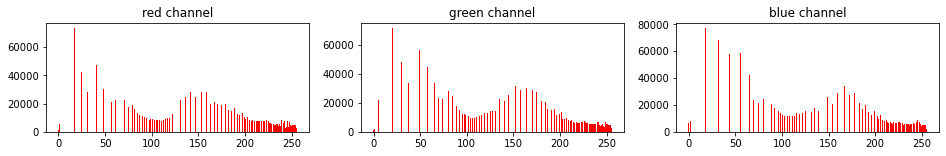

In [7]:
original_image = cv2.imread('img/night4.jpeg')
corrected_image = color_correction_by_equalizing_histogram_in_rgb(original_image)

plot_images(original_image, corrected_image, need_histogram=True)

Original and corrected images


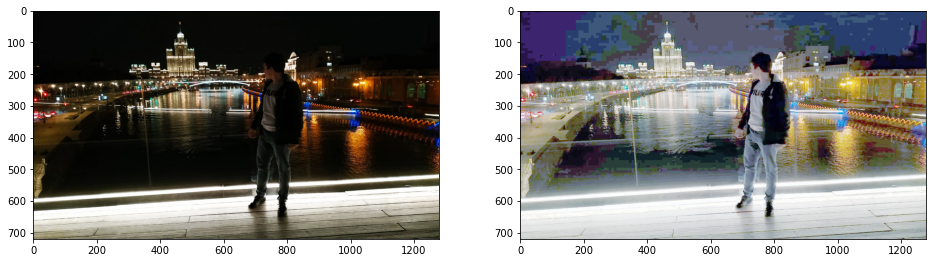

Original image histogram (in RGB)


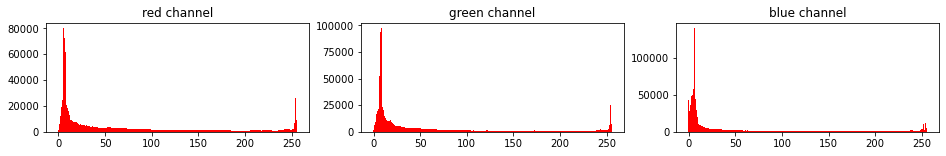

Corrected image histogram (in RGB)


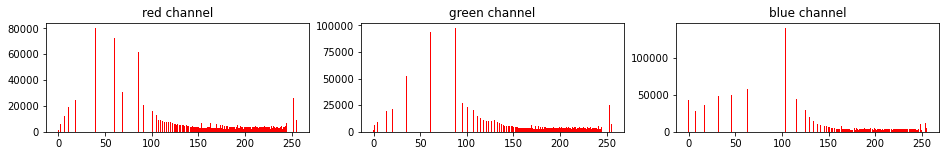

In [8]:
original_image = cv2.imread('img/moscow1.jpg')
corrected_image = color_correction_by_equalizing_histogram_in_rgb(original_image)

plot_images(original_image, corrected_image, need_histogram=True)

### HSV

Original and corrected images


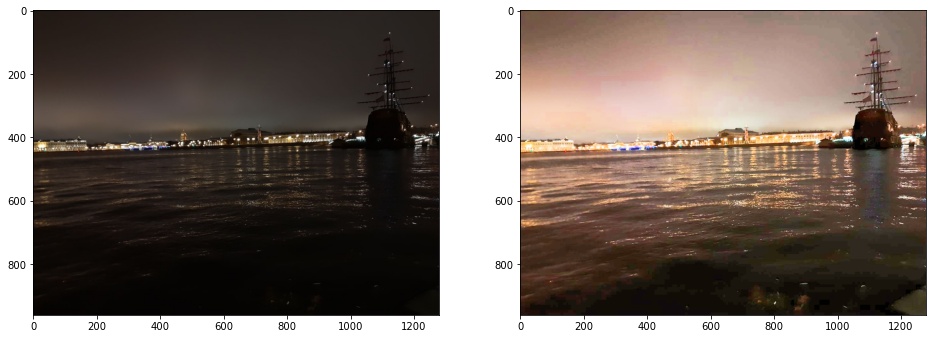

Original image histogram (in RGB)


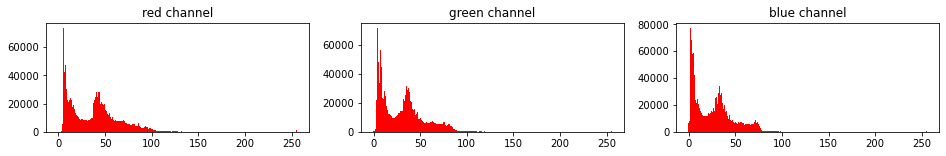

Corrected image histogram (in RGB)


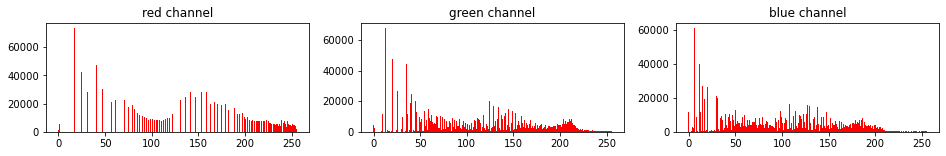

In [9]:
original_image = cv2.imread('img/night4.jpeg')
corrected_image = color_correction_by_equalizing_histogram_in_hsv(original_image)

plot_images(original_image, corrected_image, need_histogram=True)

Original and corrected images


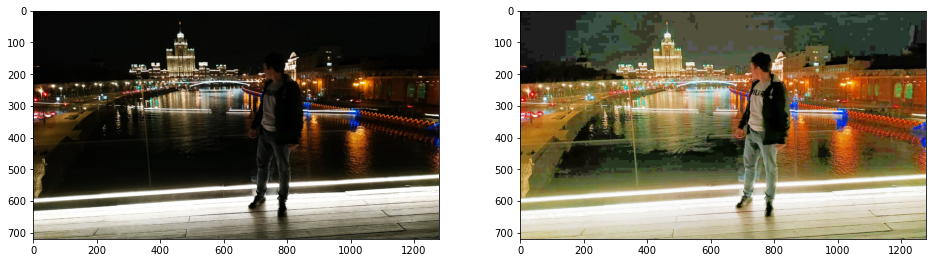

Original image histogram (in RGB)


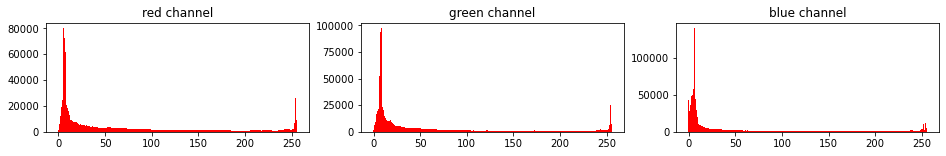

Corrected image histogram (in RGB)


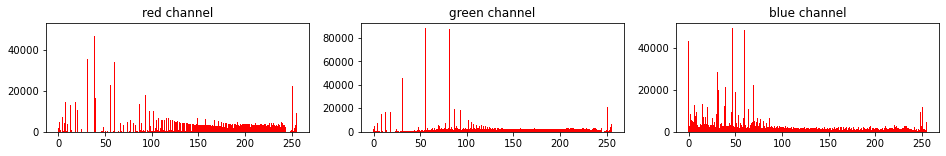

In [10]:
original_image = cv2.imread('img/moscow1.jpg')
corrected_image = color_correction_by_equalizing_histogram_in_hsv(original_image)

plot_images(original_image, corrected_image, need_histogram=True)

## Преобразование + нормализация гистограммы

Original and corrected images


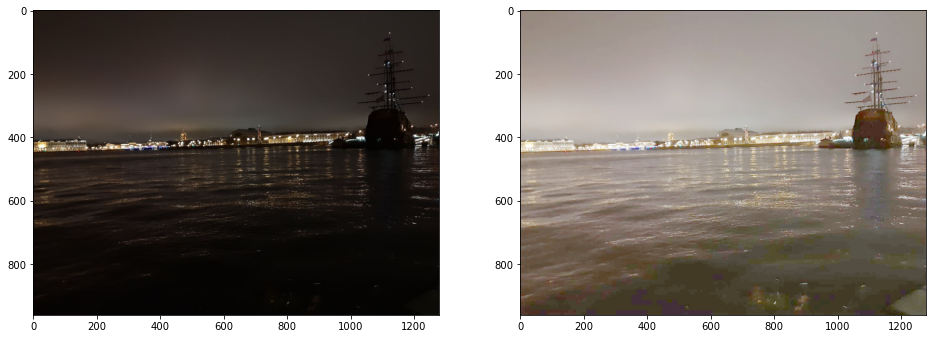

Original image histogram (in RGB)


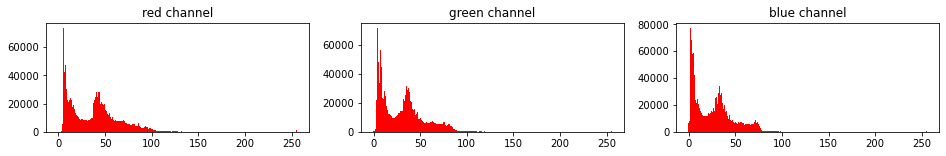

Corrected image histogram (in RGB)


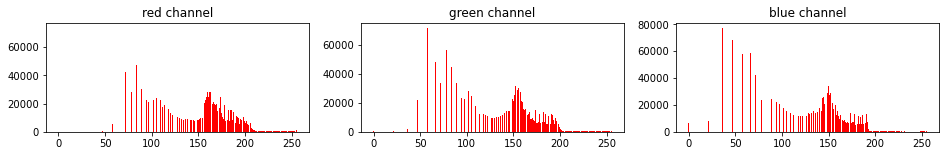

In [19]:
original_image = cv2.imread('img/night4.jpeg')

function = lambda x: math.log(x + 2) * 25
corrected_image = color_correction_by_func(original_image, function)
corrected_image = color_correction_by_normalizing_hist(corrected_image)

plot_images(original_image, corrected_image, need_histogram=True)

Original and corrected images


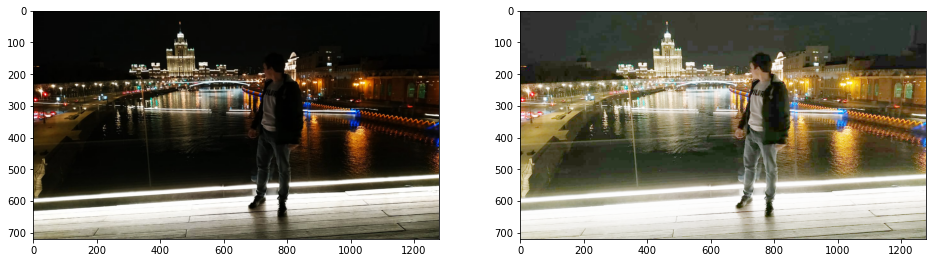

Original image histogram (in RGB)


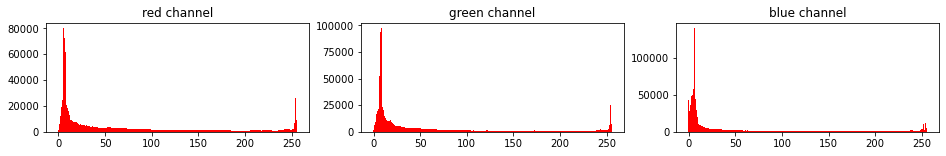

Corrected image histogram (in RGB)


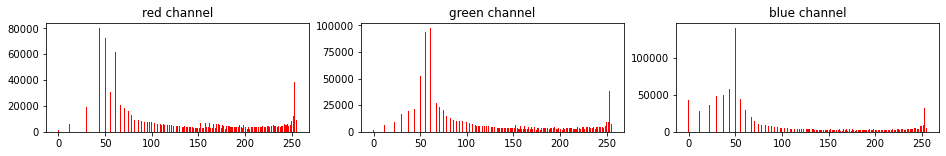

In [12]:
original_image = cv2.imread('img/moscow1.jpg')

function = lambda x: math.log(x + 5) * 25
corrected_image = color_correction_by_func(original_image, function)
corrected_image = color_correction_by_normalizing_hist(corrected_image)

plot_images(original_image, corrected_image, need_histogram=True)

Original and corrected images


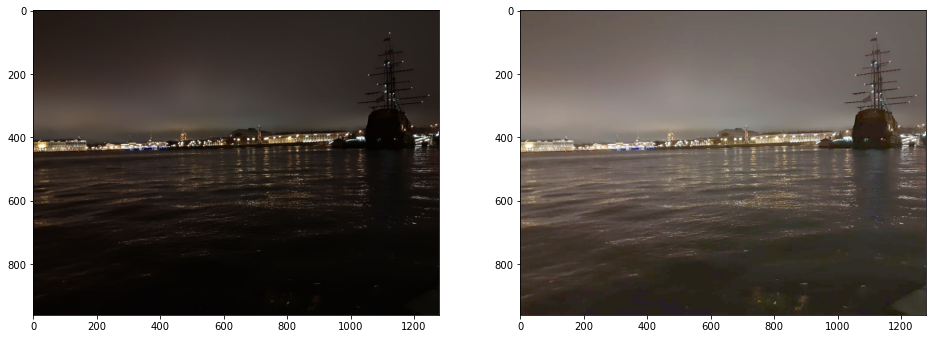

Original image histogram (in RGB)


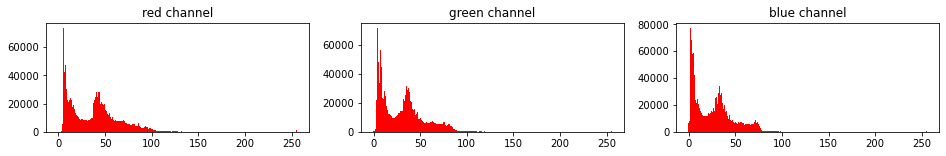

Corrected image histogram (in RGB)


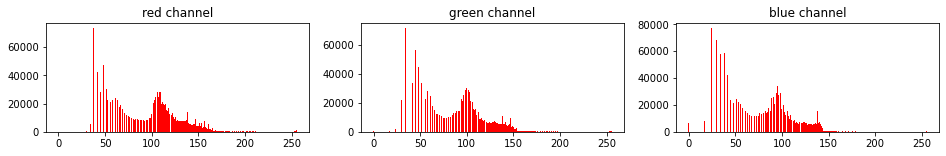

In [13]:
original_image = cv2.imread('img/night4.jpeg')

bad_function = lambda x: 15 * x**0.48
corrected_image = color_correction_by_func(original_image, bad_function)
corrected_image = color_correction_by_normalizing_hist(corrected_image)

plot_images(original_image, corrected_image, need_histogram=True)

Original and corrected images


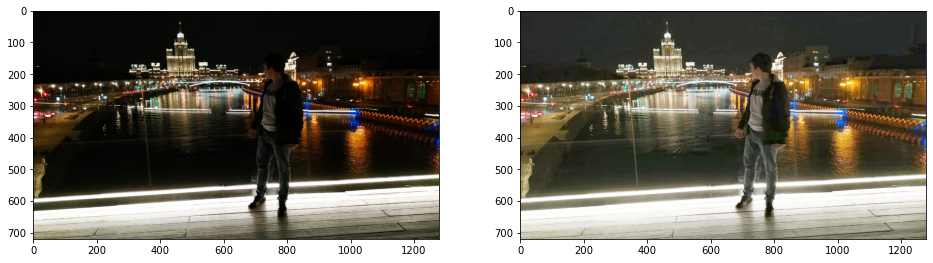

Original image histogram (in RGB)


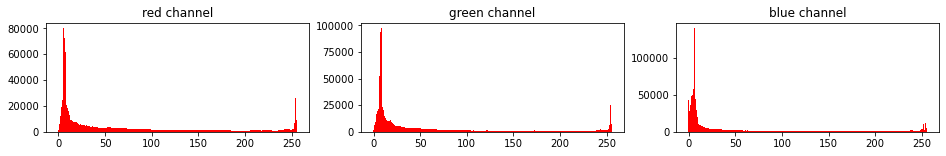

Corrected image histogram (in RGB)


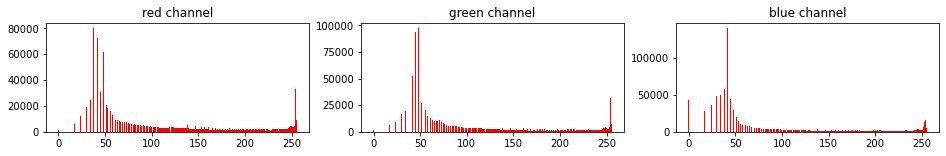

In [73]:
original_image = cv2.imread('img/moscow1.jpg')

bad_function = lambda x: 15 * x**0.48
corrected_image = color_correction_by_func(original_image, bad_function)
corrected_image = color_correction_by_normalizing_hist(corrected_image)

plot_images(original_image, corrected_image, need_histogram=True)

## Threshold

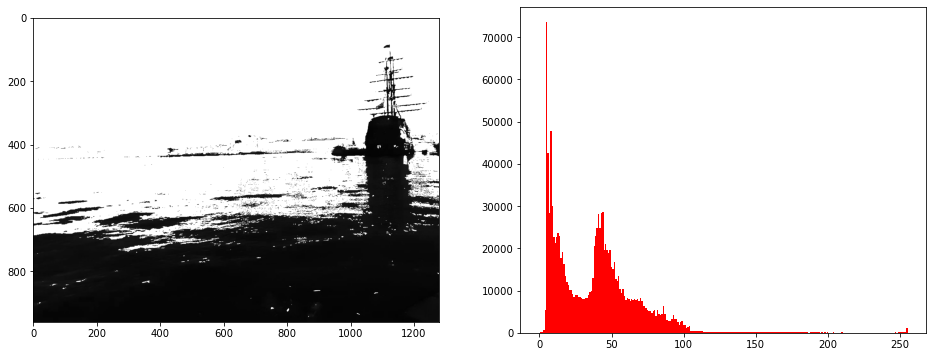

In [75]:
original_image = cv2.imread('img/night4.jpeg')

h, s, l = cv2.split(cv2.cvtColor(original_image, cv2.COLOR_BGR2HSV))

# plt.imshow(l, cmap='gray')
histogram, _ = np.histogram(l, bins=256)

l[l > 25] = 255

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].imshow( l, cmap='gray')
ax[1].bar(range(256), histogram, color='red', width=1.0)
plt.show()
# merged = np.dstack((h, s, l)).astype('uint8')